In [264]:
import cv2
import numpy as np
import os
import seaborn as sns
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Flatten, 
    Dense, 
    Activation,
    BatchNormalization,
    Dropout
)

# Load the Dataset

In [2]:
url_train = "/kaggle/input/tomatoleaf/tomato/train"
url_val = "/kaggle/input/tomatoleaf/tomato/val"

In [3]:
# Check if there is another format except jpg
num = 0
for folder in os.listdir(url_train):
    path = os.path.join(url_train,folder)
    for file in os.listdir(path):
        if file.split(".")[-1] == "jpg":
            num += 1
            #print(file)

print(num)

89


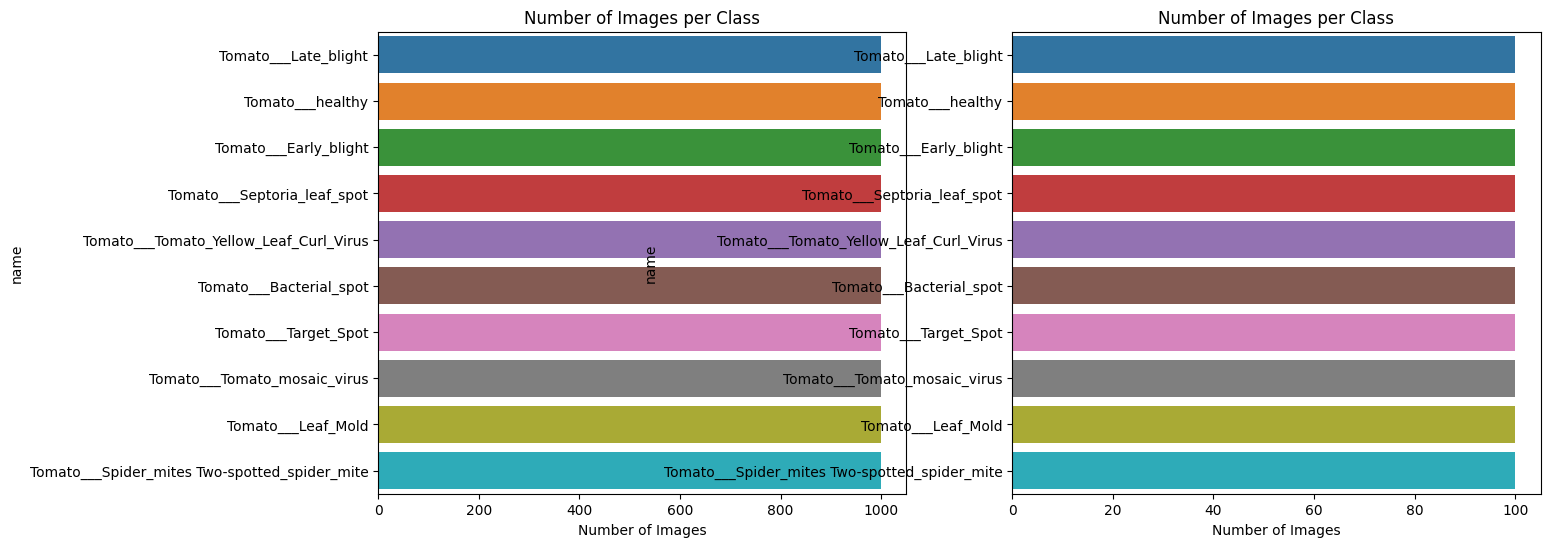

In [4]:
def visualize_the_datase(url):
    lol = []
    # Iterasi direktori
    for folder in os.listdir(url):  # url_train harus berupa path ke folder utama
        path = os.path.join(url, folder)
        if os.path.isdir(path):  # Pastikan hanya direktori yang diproses
            temp = os.listdir(path)
            # Tambahkan baris baru ke DataFrame
            lol.append({"name": str(folder), "len": len(temp)})

    n_data = pd.DataFrame(lol)

    return n_data


n_train_df = visualize_the_datase(url_train)
n_val_df = visualize_the_datase(url_val)

temp = [n_train_df, n_val_df]


plt.figure(figsize=(15, 6))
for i, df in enumerate(temp):
    plt.subplot(1,2,i+1)
    sns.barplot(y=df.name, x=df.len)
    
    plt.xlabel("Number of Images")
    plt.title("Number of Images per Class")
    #plt.xticks(rotation=90)

plt.show()

In [31]:
lol = []
# Iterasi direktori
for folder in os.listdir(url_train):  # url_train harus berupa path ke folder utama
    path = os.path.join(url_train, folder)
    for file in os.listdir(path):  # Pastikan hanya direktori yang diproses
        full_path = os.path.join(path, file)
        
        lol.append({"path": full_path, "label":folder.split('___')[-1]})

n_data = pd.DataFrame(lol)
n_data.tail(3)

,path,label
9997,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,Spider_mites Two-spotted_spider_mite
9998,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,Spider_mites Two-spotted_spider_mite
9999,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,Spider_mites Two-spotted_spider_mite


In [273]:
n_data.label.unique()

array(['Late_blight', 'healthy', 'Early_blight', 'Septoria_leaf_spot',
       'Tomato_Yellow_Leaf_Curl_Virus', 'Bacterial_spot', 'Target_Spot',
       'Tomato_mosaic_virus', 'Leaf_Mold',
       'Spider_mites Two-spotted_spider_mite'], dtype=object)

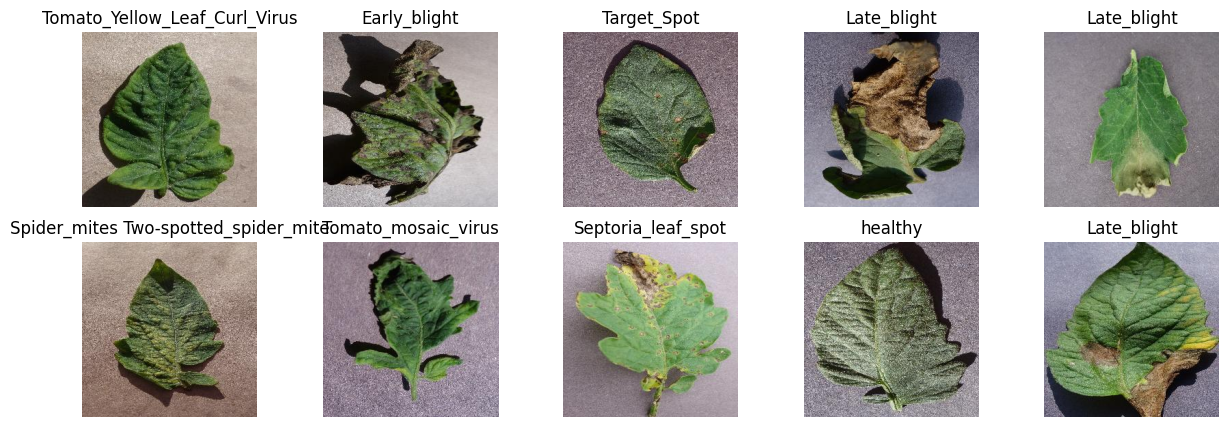

(256, 256, 3)
uint8


In [325]:
plt.figure(figsize=(15,5))

num_r = np.random.randint(0, len(n_data), 10)
for i, n in enumerate(num_r):
    plt.subplot(2,5,i+1)
    img = cv2.imread(n_data.path.loc[n])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(n_data.label.loc[n])
    plt.axis('off')

plt.show()
print(img.shape)
print(img.dtype)

# We don't need a Background, so we **segment it** (Using *Color Features*)

After comparing HSV and Lab Features, it can be concluded that **Lab** Features is more accurate in performing image segmentation than **HSV**.

1918


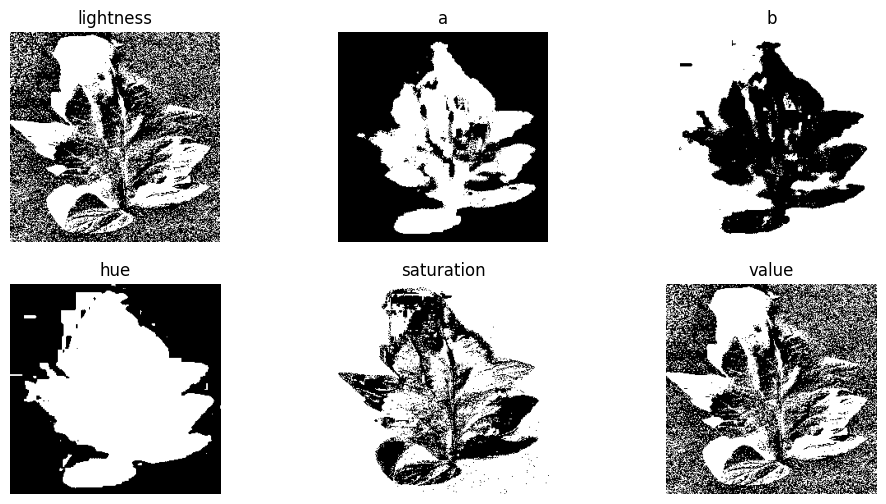

In [237]:
def segmentation_color_features(img):
    #temp = []
    
    #sampleee = imgrgb1.copy()
    #blurred = cv2.GaussianBlur(img_hsv_c, (3,3), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(img)

    #gradient = cv2.morphologyEx(clahe_img, cv2.MORPH_GRADIENT, np.ones((3, 3), np.uint8))
    _, binary = cv2.threshold(clahe_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    #temp.append(binary)
        
    return binary

# -------------------------------------------------------------------------------------------------------------------------

num_r = np.random.randint(0, len(n_data))
path = n_data['path'][num_r]  
print(num_r)

img = cv2.imread(path)
#imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Lab ------------------------------------------------------------------
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
lightness = img_lab[:,:,0]
a = img_lab[:,:,1]
b = img_lab[:,:,2]


# HSV ------------------------------------------------------------------
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue = img_hsv[:,:,0]
saturation = img_hsv[:,:,1]
value = img_hsv[:,:,2]


hsv_list = [lightness, a, b, hue, saturation, value]
titles = ['lightness', 'a', 'b', 'hue', 'saturation', 'value']
plt.figure(figsize=(12,6))


for i, n in enumerate(hsv_list):
    binary_img = segmentation_color_features(n)

    plt.subplot(2,3,i+1)
    plt.imshow(binary_img, cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.show()


In [281]:
def segmentation_LAB_features(img):
    #temp = []
    imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert into Lab -----------------------------------------------------------------------------------------------
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    a = img_lab[:,:,1]   # Extract 'a' channel from Lab Img

    
    #blurred = cv2.GaussianBlur(img_hsv_c, (3,3), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(a)

    #gradient = cv2.morphologyEx(clahe_img, cv2.MORPH_GRADIENT, np.ones((3, 3), np.uint8))
    _, binary = cv2.threshold(clahe_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Masking using CONTOURS (FILLED)----------------------------------------------------------------------------------
    mask = np.zeros_like(imgrgb)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(mask, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    result = cv2.bitwise_and(imgrgb, mask)
        
    return result

### Sample

3450
(256, 256, 3)


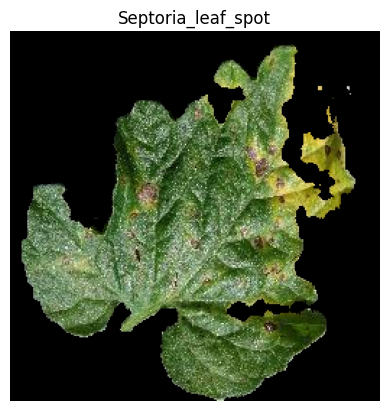

In [282]:
num_r = np.random.randint(0, len(n_data))
path = n_data['path'][num_r]  
print(num_r)
img = cv2.imread(path)

contours = segmentation_LAB_features(img)
print(contours.shape)

plt.imshow(contours, cmap='gray')
plt.title(n_data['label'][num_r])
plt.axis('off')
plt.show()

# Model

In [276]:
IMG_H, IMG_W = (224, 224)

### Custom Preprocessing Function

In [392]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess_and_segment(img):
    # Apply segmentation
    segmented_img = segmentation_LAB_features(img)
    
    # Resize to InceptionV3 input size (e.g., 299x299)
    resized_img = cv2.resize(segmented_img, (IMG_H, IMG_W))
    
    # Convert to array and normalize (as required by InceptionV3)
    resized_img = np.array(resized_img, dtype=np.float32)
    resized_img = preprocess_input(resized_img)  # Apply InceptionV3 preprocessing
    
    return resized_img

###  Data Generator

In [445]:
def custom_generator(dataframe, image_column, label_column, batch_size):
    datagen = ImageDataGenerator()  # For basic augmentation
    data_iter = datagen.flow_from_dataframe(
        dataframe,
        x_col = image_column,
        y_col = label_column,
        target_size = (IMG_H, IMG_W),  # Required by InceptionV3
        batch_size = batch_size,
        class_mode = 'sparse',  # Modify based on your use case
        shuffle = True,
        validate_filenames = False
    )

    while True:
        # Get a batch of data
        batch_x, batch_y = next(data_iter)

        # Apply segmentation preprocessing
        batch_x_processed = np.array([preprocess_and_segment(img.astype('uint8')) for img in batch_x]) 
        
        yield batch_x_processed, batch_y

    # Get a batch of data
    #batch_x, batch_y = next(data_iter)
    #batch_x_processed = np.array([preprocess_and_segment(img.astype('uint8')) for img in batch_x])

    #yield batch_x_processed, batch_y

In [279]:
# InceptionV3
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.InceptionV3(
        input_shape=(IMG_H, IMG_W, 3),
        include_top=False,
        weights="imagenet")(inputs)
    
    return feature_extractor

def nn_layers(inputs):
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation="relu", 
    #                          kernel_regularizer = tf.keras.regularizers.l2(0.01)
                             )(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    
    return output

def define_compile_model():
    input = tf.keras.layers.Input(shape=(IMG_H, IMG_W, 3))
    pretrained_output = feature_extractor(input)
    output = nn_layers(pretrained_output)

    model = tf.keras.Model(inputs=input, outputs = output)
     
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [420]:
from IPython.display import clear_output

model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

#model.layers[1].summary()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_284         │ (None, 5, 5, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,865,194 (87.22 MB)

 Trainable params: 1,058,314 (4.04 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [442]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, 
                                     mode='max',
                                     restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                         patience=3, 
                                         min_lr=1e-6)
]

In [446]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(n_data, test_size=0.2, stratify=n_data['label'], random_state=42)

print("Training DataFrame:\n", train_df.shape)
print("Testing DataFrame:\n", test_df.shape)

Training DataFrame:
 (8000, 2)
Testing DataFrame:
 (2000, 2)


In [451]:
train_gen = custom_generator(train_df, 'path', 'label', batch_size=32)
val_gen = custom_generator(test_df, 'path', 'label', batch_size=32)

model.fit(train_gen, 
          validation_data=val_gen,
          epochs = 10,
          steps_per_epoch = int((len(train_df)//32) * 0.5), 
          validation_steps = int(len(test_df)//32), 
          callbacks= [callbacks]
         )

Found 8000 non-validated image filenames belonging to 10 classes.
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6216 - loss: 1.1600Found 2000 non-validated image filenames belonging to 10 classes.
125/125 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.6219 - loss: 1.1592 - val_accuracy: 0.6930 - val_loss: 0.9707 - learning_rate: 1.0000e-04
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.6850 - loss: 0.9328 - val_accuracy: 0.7398 - val_loss: 0.8181 - learning_rate: 1.0000e-04
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.7833 - loss: 0.7128 - val_accuracy: 0.7485 - val_loss: 0.7466 - learning_rate: 1.0000e-04
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.7836 - loss: 0.6758 - val_accuracy: 0.7708 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.8374 - loss: 0.5479 - val_accuracy: 0.7820 - val_loss: 0.6570 - learning_rate: 1.0000e-04
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.8292 - loss: 0.5469 - val_accuracy: 0.7901 - val_loss: 0.6393 - learning_rate: 1.0000e-04
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.8684 - loss: 0.4439 - val_accuracy: 0.7907 - val_loss: 0.6158 - learning_rate: 1.0000e-04
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.86

In [ ]:
model.evaluate(val_gen)

# Saving Model

In [504]:
# Saving Model
model.save("Tomato_Leaf_disease_ColorFeatures+inception_v3.h5")

# Testing

In [484]:
num_samples = 200
if len(n_data) >= num_samples:
    random_indices = np.random.choice(n_data.index, num_samples, replace=False)
    testing_df = n_data.loc[random_indices]

testing_df.head()

,path,label
2480,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,Early_blight
8631,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,Leaf_Mold
2282,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,Early_blight
9114,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,Spider_mites Two-spotted_spider_mite
1185,/kaggle/input/tomatoleaf/tomato/train/Tomato__...,healthy


In [502]:
datagen = ImageDataGenerator()  # For basic augmentation
data_iter = datagen.flow_from_dataframe(
    testing_df,
    x_col = 'path',
    y_col = 'label',
    target_size = (IMG_H, IMG_W),  # Required by InceptionV3
    batch_size = -1,
    class_mode = 'sparse',  # Modify based on your use case
    shuffle = True,
    validate_filenames = False
    )

# Get a batch of data
batch_x, batch_y = next(data_iter)
batch_x_processed = np.array([preprocess_and_segment(img.astype('uint8')) for img in batch_x])
print(batch_x_processed.shape, batch_y.shape)

Found 200 non-validated image filenames belonging to 10 classes.
(199, 224, 224, 3) (199,)


In [503]:
from sklearn.metrics import classification_report

y_pred = model.predict(batch_x_processed)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(batch_y, y_pred_bool))

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94        25
         1.0       0.93      0.72      0.81        18
         2.0       0.90      0.96      0.93        28
         3.0       0.94      0.94      0.94        17
         4.0       0.94      0.94      0.94        18
         5.0       1.00      0.89      0.94        19
         6.0       0.95      0.95      0.95        21
         7.0       0.86      1.00      0.92        12
         8.0       1.00      1.00      1.00        20
         9.0       0.91      0.95      0.93        21

    accuracy                           0.93       199
   macro avg       0.94      0.93      0.93       199
weighted avg       0.94      0.93      0.93       199



# If you found my Notebook helpful or learned something new, please consider supporting me by upvoting. Thank you for your support! ❤️